# **ADM Homework 5 - USA Airport Flight Analysis**

### Import Dataset and Libraries

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download flashgordon/usa-airport-dataset

In [46]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re
from collections import defaultdict
import folium

We unzip the file downloaded from Kaggle and save it to our current working directory.

In [5]:
# Unzip the file we downloaded from kaggle
zip_file_path = 'usa-airport-dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.') # extract files to current working directory

Now we save the data in a CSV file:

In [2]:
df = pd.read_csv('Airports2.csv')
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


### Data Cleaning

According to the source website https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset, this dataset (with data from the OpenFlights website) contains over 3.5 million US Domestic Flights from 1990 to 2009.

It contains the following features:

1. `Origin_airport`: Three letter airport code of the origin airport  
2. `Destination_airport`: Three letter airport code of the destination airport  
3. `Origin_city`: Origin city name  
4. `Destination_city`: Destination city name  
5. `Passengers`: Number of passengers transported from origin to destination  
6. `Seats`: Number of seats available on flights from origin to destination  
7. `Flights`: Number of flights between origin and destination (multiple records for one month, many with flights > 1)  
8. `Distance`: Distance (to nearest mile) flown between origin and destination  
9. `Fly_date`: The date (yyyymm) of flight  
10. `Origin_population`: Origin city's population as reported by US Census  
11. `Destination_population`: Destination city's population as reported by US Census  
12. `Org_airport_lat`: latitude of the origin airport  
13. `Org_airport_long`: longitude of the origin airport  
14. `Dest_airport_lat`: latitude of the destination airport  
15. `Dest_airport_long`: longitude of the destination airport

Here we can see the shape of the dataset:

In [3]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns {df.shape[1]}')

Number of rows: 3606803
Number of columns 15


Now we look for missing values:

In [4]:
# Look for missing values
missing_counts = df.isnull().sum()
missing_counts

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

The most important features have no missing values, and the missing rows in the latitude and longitude columns can be dealt with later if it is needed, for example by looking up these values for the corresponding airports.

Next, we do a data type integrity check. `Passengers`, `Seats`, `Flights`, `Origin_population`, `Destination_population` should be integers, `Distance` and the coordinates columns should be numeric (float or integer), and `Fly_date` should be in date format.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


All data types seem correct, but it would be good to convert the `Fly_date` column type from object to datetime. The dataset description specified that dates should be in yyyymm format, however we can see from the output that there are three date entries. We could check to see if one of them indicates days.

In [6]:
# Check if day>12 or month>12 somewhere to figure out date format
for date in df['Fly_date']:
    year, entry2, entry3 = map(int, date.split('-'))
    if entry2>12:
        print('Format is yyyy-dd-mm')
    if entry3>13:
        print('Format is yyyy-mm-dd')

# See if the third date entry is different from '01' somewhere
for date in df['Fly_date']:
    year, entry2, entry3 = map(str, date.split('-'))
    if entry3 != '01':
        print(date)

Since neither the second nor third entry in the date contain values above 13, but all the dates contain '01' at the end, it could be that the '01' is just a placeholder for the day, but doesn't carry any special meaning. For this reason, we decide to treat `Fly_date` values as months, and remove the placeholder.

In [7]:
df['Fly_date'] = df['Fly_date'].apply(lambda x: re.sub(r'-01$', '', x))

Now we convert the column to datetime, with period 'M' for month.

In [8]:
df['Fly_date'] = pd.to_datetime(df['Fly_date'], format='%Y-%m').dt.to_period('M')

We can verify if there are any duplicates, and if there are, create a copy `df2` of the dataset without duplicate rows.

In [9]:
# Count number of duplicates
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Save a copy of the dataset without the duplicates
df2 = df.drop_duplicates()
print(f'Number of rows after removing duplicates: {df2.shape[0]}')

Number of duplicate rows: 41753
Number of rows after removing duplicates: 3565050


Now we check if the latitude and longitude data is valid. Latitude values, if not missing, should be in the interval [-90,90], and longitude values in the interval [-180, 180].

In [10]:
# Check if not missing latitude values are in [-90, 90]
print(f' Mininum latitude: {df['Org_airport_lat'].min()}, Maximum latitude: {df['Org_airport_lat'].max()}')

# Check if not missing longitude values are in [-180, 180]
print(f' Mininum longitude: {df['Org_airport_long'].min()}, Maximum longitude: {df['Org_airport_long'].max()}')

 Mininum latitude: 19.721399307251, Maximum latitude: 64.83750153
 Mininum longitude: -157.921997070312, Maximum longitude: -68.8281021118164


Additionally, we would like the number of passengers to not exceed the number of seats:

In [11]:
# Check if number of passangers is greater than number of seats
print(f'Number of rows for which number of passengers is greater than number of seats: {df[df['Passengers']>df['Seats']].shape[0]}')

Number of rows for which number of passengers is greater than number of seats: 280


There are 280 flights with more passengers than seats, which is a problematic that can happen if there is overbooking. Sometimes, airlines might sell more tickets than there are seats because there could be passangers that cancel or do not show up.

Lastly, we want to make sure that the same airport code is not associated with different cities:

In [12]:
# Group by 'Destination_airport' and count unique values of 'Destination_city' (we want all 1s)
dest_max__num_cities_for_code = max(df2.groupby('Destination_airport')['Destination_city'].nunique())
print(f'Maximum number of cities associated with a destination airport code: {dest_max__num_cities_for_code}')

# Group by 'Origin_airport' and count unique values of 'Origin_city' (we want all 1s)
origin_max__num_cities_for_code = max(df2.groupby('Origin_airport')['Origin_city'].nunique())
print(f'Maximum number of cities associated with an origin airport code: {origin_max__num_cities_for_code}')

Maximum number of cities associated with a destination airport code: 1
Maximum number of cities associated with an origin airport code: 1


Perfect, every airport code only has one associated city.

Next, we calculate the number of self-loops:

In [13]:
self_loops_df = df2[df2['Origin_airport']==df2['Destination_airport']]
self_loop_count = self_loops_df.shape[0]
print(f'Number of self-loops (origin airport = destination airport): {self_loop_count}')

Number of self-loops (origin airport = destination airport): 6068


If we don't want to loose information, we may choose to keep internal flights for now.

We would also like to see if values in the `Seats` column are positive:

In [14]:
print(f'Percentage of positive Seat number values: {round(df2[df2['Seats'] > 0 ].shape[0] / df2.shape[0] *100,2)} %')
print(f'Percentage of fligths with with Seat number 0: {round(df2[df2['Seats']  == 0 ].shape[0] / df2.shape[0] *100,2)} %')

Percentage of positive Seat number values: 91.76 %
Percentage of fligths with with Seat number 0: 8.24 %


Most flights contain a valid number of seats, but 8.24% of flight data have null seat number, which could indicate anomalies or missing data. These rows could also refer to empty or special flights, but the percentage is a bit high for that.

In [15]:
print(f'Number of rows where Seats=0 and Passengers>0: {df2[(df2['Seats']  == 0) & (df2['Passengers'] > 0)].shape[0]}')

Number of rows where Seats=0 and Passengers>0: 10


Since the number of rows with null number of seats and positive number of passengers is very low, when calculating the passenger flows later, we may choose to skip the rows that contain null seats data.

### Create the Graph

To work with the airline graph, we will create a directed graph class:

In [16]:
# Custom DiGraph Class
class CustomDiGraph:
    def __init__(self):
        '''Initialization of an empty graph'''
        self.nodes = set()  # set to store nodes
        self.edges = defaultdict(set) # default dictionary to store edges: key=node, value=set of neighbors

    def add_node(self, node):
        '''Function to add a node to the graph'''
        self.nodes.add(node)

    def add_edge(self, node1, node2):
        '''Function that adds an outgoing edge from node1 to node2'''
        # Add node1 and node2 to set of nodes in case they are not already in it
        self.add_node(node1)
        self.add_node(node2)
        self.edges[node1].add(node2) # add node2 to set of neighbors of node1

    def remove_node(self, node):
        '''Function that removes a node and all edges connected to it'''
        if node in self.nodes:
            self.nodes.remove(node)
            del self.edges[node]  # Remove the node from the edges dictionary
            # Remove any edges that point to this node
            for other_node in list(self.edges.keys()):
                self.edges[other_node].discard(node)

    def remove_edge(self, node1, node2):
        '''Function that removes an edge from node1 to node2'''
        self.edges[node1].discard(node2)

    def remove_all_edges(self, node1, node2):
        '''Function that removes any edge between node1 and node2'''
        self.edges[node1].discard(node2)
        self.edges[node2].discard(node1)
    
    def get_neighbors(self, node):
        '''Function that returns the neighbors of a node'''
        return self.edges[node]

    def get_nodes(self):
        '''Function that returns a list of all nodes'''
        return list(self.nodes)

    def get_edges(self):
        '''Function that returns a set of all edges as tuples (node1, node2)'''
        edge_set = set()
        for node1 in self.nodes:
            for node2 in self.get_neighbors(node1):
                edge_set.add((node1, node2))
        return edge_set
    
    def has_edge(self, node1, node2):
        '''Function that returns True if there is an edge between node1 and node2'''
        return node2 in self.get_neighbors(node1)

    def out_degree(self, node):
        '''Returns the out-degree of a node (number of outgoing edges)'''
        if node in self.edges:
            return len(self.edges[node])
        else:
            return 0
    
    def in_degree(self, node):
        '''Returns the in-degree of a node (number of incoming edges)'''
        num_in_edges = 0
        for neighbor in self.nodes:
            if node in self.edges[neighbor]:
                num_in_edges += 1
        return num_in_edges

    def __str__(self):
        '''Function that returns a string representation of the graph'''
        return f'Nodes: {self.nodes}\nEdges: {self.get_edges()}'
    
    def to_networkx_digraph(self):
        '''Function that converts the custom graph to a NetworkX DiGraph'''
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node)
        for node1, neighbors in self.edges.items():
            for node2 in neighbors:
                G.add_edge(node1, node2)
        return G
    
    def num_nodes(self):
        '''Function that returns the number of nodes in the graph'''
        return len(self.nodes)
    
    def num_edges(self):
        '''Function that returns the number of edges in the graph'''
        return len(self.get_edges())

In [17]:
# Custom Undirected Graph Class
class CustomGraph:
    def __init__(self):
        '''Initialization of an empty graph'''
        self.nodes = set()  # set to store nodes
        self.edges = defaultdict(set)  # default dictionary to store edges: key=node, value=set of neighbors

    def add_node(self, node):
        '''Function to add a node to the graph'''
        self.nodes.add(node)

    def add_edge(self, node1, node2):
        '''Function that adds an edge between node1 and node2'''
        self.add_node(node1)
        self.add_node(node2)
        self.edges[node1].add(node2)
        self.edges[node2].add(node1)

    def remove_node(self, node):
        '''Function that removes a node and all edges connected to it'''
        if node in self.nodes:
            self.nodes.remove(node)
            del self.edges[node]
            for other_node in list(self.edges.keys()):
                self.edges[other_node].discard(node)

    def remove_edge(self, node1, node2):
        '''Function that removes edge between node1 and node2'''
        self.edges[node1].discard(node2)
        self.edges[node2].discard(node1)

    def get_neighbors(self, node):
        '''Function that returns the neighbors of a node'''
        return self.edges[node]

    def get_nodes(self):
        '''Function that returns a list of all nodes'''
        return list(self.nodes)

    def get_edges(self):
        '''Function that returns a set of all edges as tuples (node1, node2)'''
        edge_set = set()
        for node1 in self.nodes:
            for node2 in self.get_neighbors(node1):
                if (node2, node1) not in edge_set:
                    edge_set.add((node1, node2))
        return edge_set

    def has_edge(self, node1, node2):
        '''Function that returns True if there is an edge between node1 and node2'''
        return node2 in self.get_neighbors(node1)

    def degree(self, node):
        '''Returns the degree of a node (number of edges connected to it)'''
        if node in self.edges:
            return len(self.edges[node])
        else:
            return 0
        
    def __str__(self):
        '''Function that returns a string representation of the graph'''
        return f'Nodes: {self.nodes}\nEdges: {self.get_edges()}'

    def to_networkx_graph(self):
        '''Function that converts the custom graph to a NetworkX Graph'''
        G = nx.Graph()
        for node in self.nodes:
            G.add_node(node)
        for node1, neighbors in self.edges.items():
            for node2 in neighbors:
                G.add_edge(node1, node2)
        return G

    def num_nodes(self):
        '''Function that returns the number of nodes in the graph'''
        return len(self.nodes)

    def num_edges(self):
        '''Function that returns the number of edges in the graph'''
        return len(self.get_edges())


Now we initialize the `flight_network` graph, add nodes to it for each airport, and directed edges for flights (from origin airport to destination airport).

In [18]:
flight_network = CustomDiGraph()

In [19]:
# Add all unique airports (origin and destination) as nodes
all_airports = set(df['Origin_airport']).union(set(df['Destination_airport']))
for airport in all_airports:
    flight_network.add_node(airport)

# Add edges to the graph
for idx in range(df2.shape[0]):
    origin = df2['Origin_airport'].iloc[idx]
    destination = df2['Destination_airport'].iloc[idx]
    # If the edge is not there yet, add the edge
    if not flight_network.has_edge(origin, destination):
        flight_network.add_edge(origin, destination)

Here we plot the graph of the USA airports network by using the networkx library (just for visualization purposes). To prevent the graph from being too messy, we did not add labels here.

Text(0.5, 1.0, 'USA Airports Network')

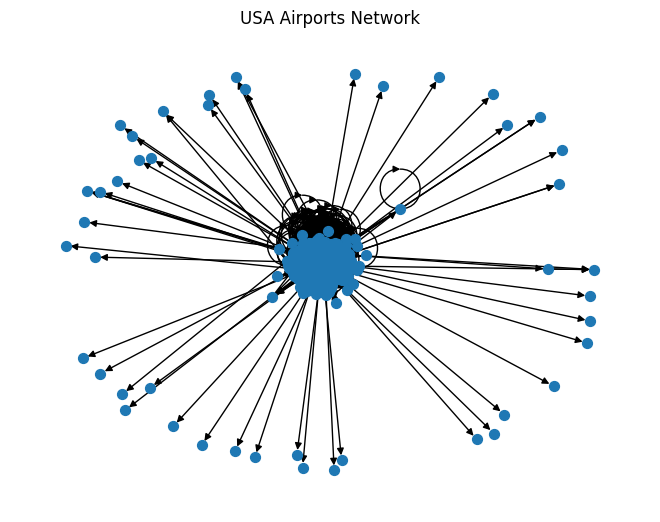

In [20]:
# Plot the graph using NetworkX
G = flight_network.to_networkx_digraph()
nx.draw(G, node_size=50)
plt.title('USA Airports Network')

Here we can check how many of the edges are reciprocated, to see if using a directed graph instead of an undirected graph was the right choice:

In [21]:
# Calculate the number of reciprocated edges
reciprocated_edges = 0
for edge in G.edges():
    # Check if the reverse edge exists (reciprocated)
    if G.has_edge(edge[1], edge[0]):
        reciprocated_edges += 1

# Calculate the percentage of reciprocated edges
if len(G.edges())>0:
    percentage_reciprocated_edges = reciprocated_edges / len(G.edges())*100
    print(f'Percentage of reciprocated edges: {percentage_reciprocated_edges:.2f}%')
else:
    print('No edges in the graph.')

Percentage of reciprocated edges: 74.04%


About 74.04% of the edges are reciprocated, so some nodes only have one-way connections, which is best represented by a directed graph.

### Implement the function ```analyze_graph_features(flight_network)```

Now we implement a function `analyze_graph_features(flight_network)` that takes the `flight_network` as input and computes:

* Number of airports (nodes) and flights (edges) in the graph.
* Density of the (directed) graph: $\frac{E}{n \cdot (n-1)}$
* Calculate in-degree and out-degree values for each airport and visualize them using histograms
* Find airports with degrees higher than the 90th percentile and list them as *hubs*
* Determine if the graph is sparse or dense based on its density

In [22]:
def analyze_graph_features(flight_network):
    '''
    Function that, given a directed input graph, computes:
    - Number of airports (nodes) and flights (edges) in the graph
    - Density of the (directed) graph
    - in-degree dictionary with key: node, value: flight_network.in_degree(node)
    - out-degree dictionary with key: node, value: flight_network.out_degree(node)
    - Hubs, airports with in-degrees or out-degrees higher than the respective 90th percentile
    - Whether the graph is sparse or dense
    Input:
    - flight_network(CustomDiGraph): custom directed graph of the flight network
    Output:
    - graph_features (dict): dictionary with information about the graph
    '''
    # Count number of airports (nodes)
    num_airports = flight_network.num_nodes()

    # Count number of flights (edges)
    num_flights = flight_network.num_edges()

    # Calculate density
    density = num_flights / (num_airports*(num_airports-1))

    # Calculate in-degrees
    in_degrees = {node: flight_network.in_degree(node) for node in flight_network.get_nodes()}

    # Calculate out-degrees
    out_degrees = {node: flight_network.out_degree(node) for node in flight_network.get_nodes()}

    # Plot histograms of in-degrees and out-degrees
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees.values(), bins=30, color='lightblue', edgecolor='black')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')
    plt.title('In-degree Distribution')
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees.values(), bins=30, color='orange', edgecolor='black')
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')
    plt.title('Out-degree Distribution')
    plt.tight_layout()

    # Calculate 90th percentile of in_degrees
    percentile_90_in_degrees = np.percentile(list(in_degrees.values()), 90)

    # Calculate 90th percentile of out_degrees
    percentile_90_out_degrees = np.percentile(list(out_degrees.values()), 90)

    # Find airports with in-degree greater than 90th percentile
    in_degree_hubs = [node for node in flight_network.get_nodes() if flight_network.in_degree(node) > percentile_90_in_degrees]
    out_degree_hubs = [node for node in flight_network.get_nodes() if flight_network.out_degree(node) > percentile_90_out_degrees]

    # Determine hubs as airports with high in-degree or out-degree
    hubs = list(set(in_degree_hubs).union(set(out_degree_hubs)))

    # Determine if the graph is dense or sparse based on the density
    threshold = 0.05
    dense = False
    if density > threshold:
        dense = True
    
    print(f'Number of airports (nodes): {num_airports}')
    print(f'Number of flights (edges): {num_flights}')
    print(f'Graph Density: {density}')
    print(f'Graph is dense: {dense}')
    print('Hubs:')
    print(hubs)
    print('Degree distributions: ')
    plt.show()

    # Create a dictionary with information do return
    graph_features = {
        'num_airports': num_airports,
        'num_flights': num_flights,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'density': density,
        'hubs': hubs
    }

    return graph_features

We apply the `analyze_graph_features` function to analyze the graph:

Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.0695696492245198
Graph is dense: True
Hubs:
['IAD', 'OMA', 'SYR', 'PDX', 'TYS', 'YIP', 'BUF', 'LIT', 'LGA', 'ATL', 'DTW', 'MEM', 'EWR', 'AUS', 'MSY', 'STL', 'SBN', 'MCO', 'MKE', 'RNO', 'ORD', 'HOU', 'BHM', 'BOS', 'OAK', 'DAY', 'RDU', 'CHA', 'MSN', 'BNA', 'COS', 'LAX', 'GSO', 'DAL', 'TUL', 'GSP', 'CLT', 'IAH', 'MSP', 'LRD', 'PIA', 'SFO', 'FLL', 'SHV', 'LAS', 'CVG', 'LAN', 'DSM', 'MDW', 'TUS', 'ICT', 'TOL', 'BWI', 'MIA', 'LEX', 'OKC', 'MCI', 'PHX', 'RFD', 'IND', 'CMH', 'DFW', 'CLE', 'ELP', 'SLC', 'ABQ', 'PHL', 'PIT', 'SEA', 'BDL', 'JAX', 'TPA', 'JFK', 'CAE', 'SAT', 'GRR', 'FWA', 'SAN']
Degree distributions: 


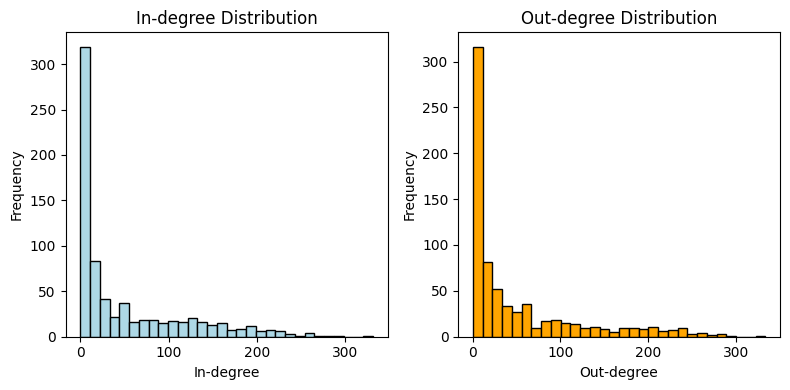

In [23]:
graph_features = analyze_graph_features(flight_network)

This analysis shows hubs by their airport code. To get a list of cities where the hubs are located, we can implement a dictionary that maps airport codes to their city, then apply it to the list of hub airport codes.

In [24]:
# Dictionary that maps codes to cities
code_to_city_dict = defaultdict(str)

# Populate code_to_city_dict
for idx in range(df2.shape[0]):
    # Origin code and city of the row
    origin_code = df2['Origin_airport'].iloc[idx]
    origin_city = df2['Origin_city'].iloc[idx]
    # Destination code and city of the row
    destination_code = df2['Destination_airport'].iloc[idx]
    destination_city = df2['Destination_city'].iloc[idx]
    # Add values to dictionary (if not already present)
    if origin_code not in code_to_city_dict.keys():
        code_to_city_dict[origin_code] = origin_city
    if destination_code not in code_to_city_dict.keys():
        code_to_city_dict[destination_code] = destination_city

Here are the cities of the hubs:

In [25]:
# List of cities with hubs
hubs_cities = [code_to_city_dict[hub] for hub in graph_features['hubs']]

# Display these cities in a DataFrame
hubs_cities_df = pd.DataFrame(hubs_cities, columns=['Hubs Cities'])
display(hubs_cities_df)

,Hubs Cities
0,"Washington, DC"
1,"Omaha, NE"
2,"Syracuse, NY"
3,"Portland, OR"
4,"Knoxville, TN"
...,...
73,"Columbia, SC"
74,"San Antonio, TX"
75,"Grand Rapids, MI"
76,"Fort Wayne, IN"


### Implement the function ```summarize_graph_features(flight_network)```

In this section, we implement a function `summarize_graph_features(flight_network)` that generates a detailed report of the features, containing the following information:
* Number of nodes (airports)
* Number of edges (flights)
* Graph density
* Degree distribution plots for in-degree and out-degree
* Table of identified hubs

In [26]:
def summarize_graph_features(flight_network):
    '''
    Function that, given a flight network, writes a report about the graph features, including:
    - Number of nodes (airports)
    - Number of edges (flights)
    - Graph density
    - Degree distribution plots for in-degree and out-degree
    - Table of identified hubs
    Inputs:
    - flight_network (CustomDiGraph): custom directed graph of the flight network
    Outputs:
    - graph_summary (dict): dictionary with summary information about the graph
    '''

    # Count number of airports (nodes)
    num_airports = flight_network.num_nodes()

    # Count number of flights (edges)
    num_flights = flight_network.num_edges()

    # Calculate density
    density = num_flights / (num_airports*(num_airports-1))

    # Print number of nodes and edges
    print(f'The network contains {num_airports} nodes and {num_flights} edges.')

    # Determine if the graph is dense or sparse based on the density, and print the result
    threshold = 0.05
    if density > threshold:
        print(f'The graph is dense with density={density}')
    else:
        print(f'The graph is not dense and has density={density}')

    # Calculate in-degrees, store them in a defaultdict
    in_degrees = defaultdict(int, {node: flight_network.in_degree(node) for node in flight_network.get_nodes()})

    # Calculate out-degrees, store them in a defaultdict
    out_degrees = defaultdict(int, {node: flight_network.out_degree(node) for node in flight_network.get_nodes()})

    # Make a table with in_degrees and out_degrees for each airport
    airport_degree_data = []
    for node in flight_network.get_nodes():
        airport_degree_data.append((node,in_degrees[node],out_degrees[node]))

    # Create table of in_degrees and out_degrees for each airport
    degree_df = pd.DataFrame(airport_degree_data, columns=['airport', 'in-degree', 'out-degree'])

    # Display in-degree and out-degree
    print('Here is a table of in-degrees and out-degrees for every airport:')
    display(degree_df) 

    # Calculate 90th percentile of in_degrees
    percentile_90_in_degrees = np.percentile(list(in_degrees.values()), 90)

    # Calculate 90th percentile of out_degrees
    percentile_90_out_degrees = np.percentile(list(out_degrees.values()), 90)

    # Find airports with in-degree greater than 90th percentile
    in_degree_hubs = [node for node in flight_network.get_nodes() if flight_network.in_degree(node) > percentile_90_in_degrees]
    out_degree_hubs = [node for node in flight_network.get_nodes() if flight_network.out_degree(node) > percentile_90_out_degrees]

    # Determine hubs as airports with high in-degree or out-degree
    hubs = list(set(in_degree_hubs).union(set(out_degree_hubs)))

    # Create a table of hubs with their respective in-degrees and out-degrees
    hub_degree_df = degree_df[degree_df['airport'].isin(hubs)]
    hub_degree_df = hub_degree_df.rename(columns={'airport':'hub'})
    
    # Display hubs
    print('The following table contains the hubs, airports with in-degree or out-degree above the')
    print(f'90th percentile of in-degrees ({round(percentile_90_in_degrees,2)}) and out-degrees ({round(percentile_90_out_degrees,2)}) respectively:')
    display(hub_degree_df)

    # Plot histograms of in-degrees and out-degrees
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees.values(), bins=30, color='lightblue', edgecolor='black')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')
    plt.title('In-degree Distribution')
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees.values(), bins=30, color='orange', edgecolor='black')
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')
    plt.title('Out-degree Distribution')
    plt.tight_layout()
    
    # Create a dictionary with information do return
    graph_summary = {
        'num_airports': num_airports,
        'num_flights': num_flights,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'density': density,
        'hubs': hubs,
        'degree_df': degree_df,
        'hub_degree_df': hub_degree_df
    }

    return graph_summary
    

The network contains 727 nodes and 36719 edges.
The graph is dense with density=0.0695696492245198
Here is a table of in-degrees and out-degrees for every airport:


,airport,in-degree,out-degree
0,WGO,7,14
1,WV1,2,2
2,AIY,1,1
3,FOE,103,103
4,CKB,60,62
...,...,...,...
722,BWG,70,58
723,VCT,28,9
724,LRU,24,18
725,BRD,30,19


The following table contains the hubs, airports with in-degree or out-degree above the
90th percentile of in-degrees (157.4) and out-degrees (171.0) respectively:


,hub,in-degree,out-degree
14,SBN,161,157
17,ORD,240,286
38,DAL,206,184
40,GSP,168,180
44,PIA,164,139
...,...,...,...
710,PHX,225,259
712,IND,255,258
714,SLC,219,249
717,ABQ,181,196


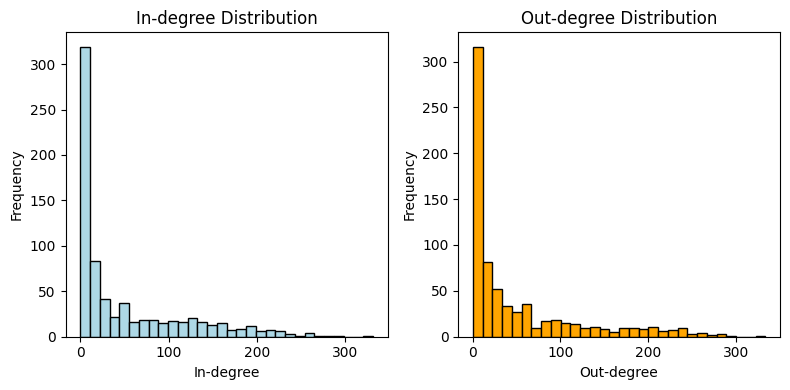

In [27]:
graph_summary = summarize_graph_features(flight_network)

### Graph Analysis

We will now analyze the graph more in detail. First, we implement a function called `total_passenger_flow` that computes the total passenger flow between two cities in the dates covered by the dataset, taking into consideration all unique flight data rows. For each (origin city, destination city) pair, it sums the minimum values between number of seats and number of passengers of the rows that the (origin city, destination city) pair appears in. It does not take into account flights where the number of seats or passengers is 0, since they add nothing to the passenger flow.

In [28]:
def total_passenger_flow(df):
    # Create defaultdict to store passenger flows between origin and destination cities
    city_route_flow = defaultdict(int)
    
    # Iterate over rows in the df, add passenger flow
    for idx in range(df.shape[0]):
        origin = df['Origin_city'].iloc[idx]
        destination = df['Destination_city'].iloc[idx]
        # Add the min between number of passengers and seats
        if df['Seats'].iloc[idx] != 0 and df['Passengers'].iloc[idx] !=0:
            city_route_flow[(origin, destination)] += min(df['Passengers'].iloc[idx], df['Seats'].iloc[idx])
    
    return city_route_flow

We compute the total passenger flow between cities:

In [29]:
city_route_flow = total_passenger_flow(df2)

,Origin_city,Destination_city,Passenger_flow
0,"Manhattan, KS","Ames, IA",21
1,"Eugene, OR","Bend, OR",24846
2,"Medford, OR","Bend, OR",492
3,"Seattle, WA","Bend, OR",529573
4,"Portland, OR","Bend, OR",1268215
...,...,...,...
23880,"Fort Smith, AR","Fort Leonard Wood, MO",26
23881,"St. Louis, MO","Fort Leonard Wood, MO",86468
23882,"Marion, IL","Fort Leonard Wood, MO",3
23883,"Kansas City, MO","Fort Leonard Wood, MO",3734


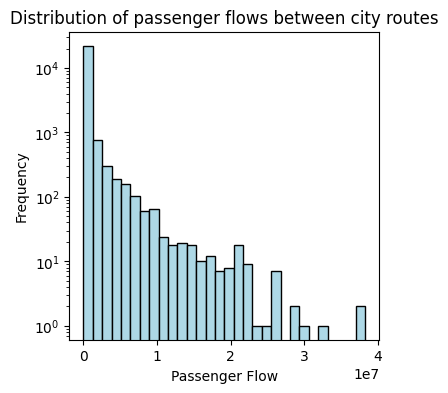

In [30]:
# Create a list of (origin, destination, flow) tuples
city_route_flow_tuples = [(cities[0], cities[1], flow) for cities, flow in city_route_flow.items()]

# Create and display a dataframe of city route flow
city_route_flow_df = pd.DataFrame(city_route_flow_tuples, columns=['Origin_city', 'Destination_city', 'Passenger_flow'])
display(city_route_flow_df)

# Histogram of passenger flows between cities
plt.figure(figsize=(4,4))
plt.hist(city_route_flow.values(), bins=30, color='lightblue', edgecolor='black', log=True)
plt.xlabel('Passenger Flow')
plt.ylabel('Frequency')
plt.title('Distribution of passenger flows between city routes')
plt.show()

Now we look for the busiest routes by passenger traffic, by looking at the routes that have a passenger flow above the 99th percentile of the passenger flow values. We discard possible self-loops.

In [104]:
# 90th percentile of passenger flows
routes_99th_percentile = np.percentile([list(city_route_flow.values())], 98)

# Find busiest routes
busy_routes = {cities:flow for cities, flow in city_route_flow.items() if ((flow >= routes_99th_percentile) and (cities[0] != cities[1]))}

# Number of extremely busy routes
print(f'Number of very busy routes: {len(busy_routes)}')

Number of very busy routes: 478


We want to visualize these busy routes, and for that we can use the `folium` library. We retrieve the coordinates of the busiest cities from the dataset, then display them on a folium map. We also display routes between cities and color them based on the passenger flow.

It is possible that a city has more than one airport. To keep the map cleaner, we only use the coordinates of one of the airports for each city to display the traffic.

First we make a dictionary of coordinates for every city:

In [70]:
# Initialize a dictionary that maps cities to their coordinates
city_coords = defaultdict(tuple)

# Initialize a dictionary that maps airports to their coordinates
airport_coords = defaultdict(tuple)

origin_cities = set(df2['Origin_city'])
dest_cities = set(df2['Destination_city'])

for node in flight_network.get_nodes():

    city = code_to_city_dict[node]

    # Not NaN coordinates for these cities
    org_coords = df2[df2['Origin_city']==city][['Org_airport_lat','Org_airport_long']].dropna()
    dest_coords = df2[df2['Destination_city']==city][['Dest_airport_lat','Dest_airport_long']].dropna()

    # Fill the city_coords dictionary with coordinates from each city
    if (city in origin_cities) and org_coords.shape[0]>0: # check if org_coords has some values
        city_coords[city] = tuple(org_coords.iloc[0])
    elif (city in dest_cities) and dest_coords.shape[0]>0: # check if org_coords has some values
        city_coords[city] = tuple(dest_coords.iloc[0])


Now we retrieve all the busy cities, and store their coordinates in a dictionary:

In [105]:
# List of busy cities
busy_cities = list(zip(*busy_routes.keys()))
first_list, second_list = list(busy_cities[0]), list(busy_cities[1])
first_list.extend(second_list)
busy_cities = set(first_list)

# Dictionary of coordinates of busy cities
busy_city_coords = {city:coords for city, coords in city_coords.items() if city in busy_cities}

# Print busy city results
print(f'Number of busy cities: {len(busy_cities)}')
print(f'Number of not missing coordinates of busy cities: {len(busy_city_coords)}')

Number of busy cities: 67
Number of not missing coordinates of busy cities: 67


In [119]:
# Latitude and longitute of the approximate center of the USA
usa_coords = [39.8283, -98.5795]

# Create a folium map centered in the USA
map = folium.Map(location=usa_coords, zoom_start=4)

# List of coordinates
coords_list = [coords for coords in busy_city_coords.values()]

# City names
cities = [city for city in busy_city_coords.keys()]

# Add cities to the map
for coord, city in zip(coords_list, cities):
    folium.Marker(location=coord, popup=city, tooltip=city).add_to(map)

for cities, passengers in busy_routes.items():

    # Get coordinates of origin and destination city
    origin_coords = busy_city_coords[cities[0]]
    destination_coords = busy_city_coords[cities[1]]

    # Create route between origin and destination city
    folium.PolyLine(locations=[origin_coords, destination_coords], color='blue', weight=1, opacity=2).add_to(map)

    # Mid point between origin and destination city
    mid_point = [(origin_coords[0]+destination_coords[0]) / 2, (origin_coords[1]+destination_coords[1]) / 2]

    # Add a marker for traffic flow value
    #folium.Marker(location=mid_point, popup=f'{passengers} passengers', icon=folium.Icon(color='lightblue', icon='info-sign')).add_to(map)


Here we display the interactive map of the busiest routes:

In [120]:
map

### Report

### Questions